<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:12:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


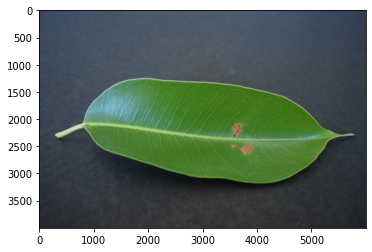

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

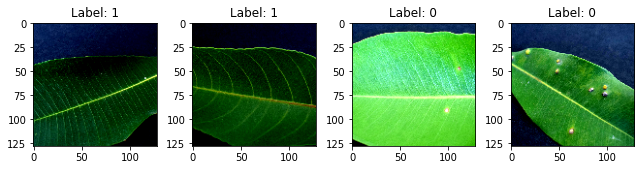

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:13:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[05:13:06] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[05:13:09] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.068681914366411 samples/sec                   batch loss = 0.8583176732063293 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2679705703413433 samples/sec                   batch loss = 0.7023386359214783 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2632901655139552 samples/sec                   batch loss = 0.8910202980041504 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2679256279786175 samples/sec                   batch loss = 0.4856472909450531 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2547157619647054 samples/sec                   batch loss = 0.4133218228816986 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.255892915491255 samples/sec                   batch loss = 0.830509603023529 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2591103457131623 samples/sec                   batch loss = 0.505597710609436 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2639794234001565 samples/sec                   batch loss = 0.5598029494285583 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2619923079411144 samples/sec                   batch loss = 0.3819686472415924 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2613624915306278 samples/sec                   batch loss = 0.5242422819137573 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.263360370317882 samples/sec                   batch loss = 1.5744484663009644 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.261274682197003 samples/sec                   batch loss = 0.27593207359313965 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2591616584544896 samples/sec                   batch loss = 0.8699005842208862 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2629191989776336 samples/sec                   batch loss = 0.6899241209030151 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.2602026123122245 samples/sec                   batch loss = 0.5219065546989441 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.257249945595058 samples/sec                   batch loss = 0.7707027196884155 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2581220454909838 samples/sec                   batch loss = 0.21051552891731262 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2640528476837058 samples/sec                   batch loss = 0.4775148928165436 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2619054549611908 samples/sec                   batch loss = 0.49719738960266113 | accuracy = 0.6078947368421053


Epoch[1] Batch[100] Speed: 1.2634734944717627 samples/sec                   batch loss = 0.3592042326927185 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2567706645921766 samples/sec                   batch loss = 0.8825784921646118 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2584416781636665 samples/sec                   batch loss = 0.5937211513519287 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2545741789868523 samples/sec                   batch loss = 1.2390456199645996 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.2596224319672245 samples/sec                   batch loss = 0.941983163356781 | accuracy = 0.6229166666666667


Epoch[1] Batch[125] Speed: 1.2580285550884114 samples/sec                   batch loss = 0.7522537112236023 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2543560029885243 samples/sec                   batch loss = 0.4873925447463989 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2592605157820231 samples/sec                   batch loss = 0.6304839253425598 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2555678106403305 samples/sec                   batch loss = 0.7969828248023987 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.2635335374702874 samples/sec                   batch loss = 0.8281925320625305 | accuracy = 0.6275862068965518


Epoch[1] Batch[150] Speed: 1.2645818307022827 samples/sec                   batch loss = 0.34931066632270813 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2650273123096347 samples/sec                   batch loss = 0.4144134223461151 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.2638135597305988 samples/sec                   batch loss = 0.9479272365570068 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.2655369686370832 samples/sec                   batch loss = 0.6692734360694885 | accuracy = 0.6424242424242425


Epoch[1] Batch[170] Speed: 1.2667774689421907 samples/sec                   batch loss = 0.6869526505470276 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.270486953652018 samples/sec                   batch loss = 0.30251607298851013 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2634376236442715 samples/sec                   batch loss = 0.43035849928855896 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.264262596703314 samples/sec                   batch loss = 0.7162479162216187 | accuracy = 0.6405405405405405


Epoch[1] Batch[190] Speed: 1.2659911480611803 samples/sec                   batch loss = 0.3144829571247101 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.2658227504283424 samples/sec                   batch loss = 0.8250606656074524 | accuracy = 0.6448717948717949


Epoch[1] Batch[200] Speed: 1.2675768340981863 samples/sec                   batch loss = 0.5694380402565002 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2734428458322096 samples/sec                   batch loss = 1.010349988937378 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2677123628888538 samples/sec                   batch loss = 0.4937851130962372 | accuracy = 0.6488095238095238


Epoch[1] Batch[215] Speed: 1.2703662214901976 samples/sec                   batch loss = 0.4768330752849579 | accuracy = 0.6465116279069767


Epoch[1] Batch[220] Speed: 1.2658674483249108 samples/sec                   batch loss = 0.6087095737457275 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.2654486726008811 samples/sec                   batch loss = 0.37022340297698975 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.2687115721914588 samples/sec                   batch loss = 0.5089991092681885 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.2639646633871964 samples/sec                   batch loss = 0.5762659311294556 | accuracy = 0.6478723404255319


Epoch[1] Batch[240] Speed: 1.2711696420987901 samples/sec                   batch loss = 0.6851966381072998 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2764248573788382 samples/sec                   batch loss = 0.5287443399429321 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.273530617591014 samples/sec                   batch loss = 1.6202316284179688 | accuracy = 0.65


Epoch[1] Batch[255] Speed: 1.2718511362782658 samples/sec                   batch loss = 0.43907323479652405 | accuracy = 0.65


Epoch[1] Batch[260] Speed: 1.2685530009319137 samples/sec                   batch loss = 0.44003576040267944 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2652546555221316 samples/sec                   batch loss = 0.499639093875885 | accuracy = 0.65


Epoch[1] Batch[270] Speed: 1.2677927360499632 samples/sec                   batch loss = 0.6810876131057739 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2688469599076901 samples/sec                   batch loss = 0.6166982650756836 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2680443632197043 samples/sec                   batch loss = 0.36519142985343933 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.2717843229528 samples/sec                   batch loss = 0.3141328692436218 | accuracy = 0.6587719298245615


Epoch[1] Batch[290] Speed: 1.2694149243048176 samples/sec                   batch loss = 0.6358152627944946 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.274068822372169 samples/sec                   batch loss = 0.7481855154037476 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.2644692704082878 samples/sec                   batch loss = 0.7646069526672363 | accuracy = 0.6641666666666667


Epoch[1] Batch[305] Speed: 1.2698709307904654 samples/sec                   batch loss = 0.46310073137283325 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2711201388917828 samples/sec                   batch loss = 1.041040062904358 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.26870399286867 samples/sec                   batch loss = 0.5614233613014221 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2682218846455284 samples/sec                   batch loss = 0.9972317814826965 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2661400974244414 samples/sec                   batch loss = 0.3224516212940216 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2697297509206311 samples/sec                   batch loss = 0.6430405378341675 | accuracy = 0.6712121212121213


Epoch[1] Batch[335] Speed: 1.269833158014802 samples/sec                   batch loss = 0.16194450855255127 | accuracy = 0.6716417910447762


Epoch[1] Batch[340] Speed: 1.2671791310663427 samples/sec                   batch loss = 0.5185030102729797 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.263665157222491 samples/sec                   batch loss = 0.4152689576148987 | accuracy = 0.6731884057971015


Epoch[1] Batch[350] Speed: 1.268043500655932 samples/sec                   batch loss = 0.20985746383666992 | accuracy = 0.6757142857142857


Epoch[1] Batch[355] Speed: 1.2629682556184125 samples/sec                   batch loss = 0.6902289986610413 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2656454225746836 samples/sec                   batch loss = 0.490321546792984 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2647045166036974 samples/sec                   batch loss = 0.5436878800392151 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.266996064788226 samples/sec                   batch loss = 0.5258766412734985 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2576478502422086 samples/sec                   batch loss = 0.5315859317779541 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2615779891350936 samples/sec                   batch loss = 0.6306896805763245 | accuracy = 0.6776315789473685


Epoch[1] Batch[385] Speed: 1.2588683911573457 samples/sec                   batch loss = 0.5222700834274292 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2684518161603988 samples/sec                   batch loss = 2.5371415615081787 | accuracy = 0.6762820512820513


Epoch[1] Batch[395] Speed: 1.265111829031654 samples/sec                   batch loss = 0.47598326206207275 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2641419015487478 samples/sec                   batch loss = 0.8039345741271973 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.259988341296309 samples/sec                   batch loss = 0.5399719476699829 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2607224086108253 samples/sec                   batch loss = 0.18452154099941254 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.261226420718277 samples/sec                   batch loss = 0.5225571393966675 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2562420807300172 samples/sec                   batch loss = 0.3339894413948059 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2622182766131125 samples/sec                   batch loss = 0.508713960647583 | accuracy = 0.6788235294117647


Epoch[1] Batch[430] Speed: 1.258247255714594 samples/sec                   batch loss = 0.5143845677375793 | accuracy = 0.6790697674418604


Epoch[1] Batch[435] Speed: 1.262317234587995 samples/sec                   batch loss = 0.8918167352676392 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.259084738156223 samples/sec                   batch loss = 0.36644983291625977 | accuracy = 0.678409090909091


Epoch[1] Batch[445] Speed: 1.2522018675383477 samples/sec                   batch loss = 0.240156888961792 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.2617603469860208 samples/sec                   batch loss = 1.03466796875 | accuracy = 0.6822222222222222


Epoch[1] Batch[455] Speed: 1.2685724724603018 samples/sec                   batch loss = 0.6353662610054016 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.2633700740346265 samples/sec                   batch loss = 0.6893258094787598 | accuracy = 0.6815217391304348


Epoch[1] Batch[465] Speed: 1.2650971379553437 samples/sec                   batch loss = 0.696104884147644 | accuracy = 0.6833333333333333


Epoch[1] Batch[470] Speed: 1.2562350259154573 samples/sec                   batch loss = 1.0081989765167236 | accuracy = 0.6824468085106383


Epoch[1] Batch[475] Speed: 1.261636428991471 samples/sec                   batch loss = 0.45507919788360596 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2608199003922267 samples/sec                   batch loss = 0.16478481888771057 | accuracy = 0.684375


Epoch[1] Batch[485] Speed: 1.2598538912703845 samples/sec                   batch loss = 0.31399208307266235 | accuracy = 0.6845360824742268


Epoch[1] Batch[490] Speed: 1.2636858115451959 samples/sec                   batch loss = 1.3705731630325317 | accuracy = 0.6841836734693878


Epoch[1] Batch[495] Speed: 1.2588992798246372 samples/sec                   batch loss = 0.572158932685852 | accuracy = 0.6858585858585858


Epoch[1] Batch[500] Speed: 1.2565349724823358 samples/sec                   batch loss = 0.48307502269744873 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.258706793515549 samples/sec                   batch loss = 0.4276771545410156 | accuracy = 0.6841584158415842


Epoch[1] Batch[510] Speed: 1.2613203870415188 samples/sec                   batch loss = 0.5766666531562805 | accuracy = 0.6838235294117647


Epoch[1] Batch[515] Speed: 1.2602849708238433 samples/sec                   batch loss = 0.4532831609249115 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2591804647236995 samples/sec                   batch loss = 0.11699735373258591 | accuracy = 0.6855769230769231


Epoch[1] Batch[525] Speed: 1.2608683202815314 samples/sec                   batch loss = 0.9331688284873962 | accuracy = 0.6861904761904762


Epoch[1] Batch[530] Speed: 1.2633248864268456 samples/sec                   batch loss = 0.6418176889419556 | accuracy = 0.6863207547169812


Epoch[1] Batch[535] Speed: 1.2676335323702153 samples/sec                   batch loss = 0.39135175943374634 | accuracy = 0.6869158878504673


Epoch[1] Batch[540] Speed: 1.2646436949764208 samples/sec                   batch loss = 0.36787474155426025 | accuracy = 0.6888888888888889


Epoch[1] Batch[545] Speed: 1.2628575983613548 samples/sec                   batch loss = 0.5705559253692627 | accuracy = 0.6889908256880733


Epoch[1] Batch[550] Speed: 1.2673478898064374 samples/sec                   batch loss = 0.2204100787639618 | accuracy = 0.69


Epoch[1] Batch[555] Speed: 1.2601137339963222 samples/sec                   batch loss = 0.5238654613494873 | accuracy = 0.6914414414414415


Epoch[1] Batch[560] Speed: 1.2658627682689858 samples/sec                   batch loss = 0.16675135493278503 | accuracy = 0.6919642857142857


Epoch[1] Batch[565] Speed: 1.2680252912501788 samples/sec                   batch loss = 0.6415435075759888 | accuracy = 0.6898230088495575


Epoch[1] Batch[570] Speed: 1.2661882578909336 samples/sec                   batch loss = 1.2870723009109497 | accuracy = 0.6899122807017544


Epoch[1] Batch[575] Speed: 1.2655475649894474 samples/sec                   batch loss = 0.4001721739768982 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.263191530483995 samples/sec                   batch loss = 0.4827551543712616 | accuracy = 0.6926724137931034


Epoch[1] Batch[585] Speed: 1.268150467513445 samples/sec                   batch loss = 0.20684513449668884 | accuracy = 0.694017094017094


Epoch[1] Batch[590] Speed: 1.2640348479455799 samples/sec                   batch loss = 0.919992208480835 | accuracy = 0.6932203389830508


Epoch[1] Batch[595] Speed: 1.2636749608030051 samples/sec                   batch loss = 0.2796068787574768 | accuracy = 0.6932773109243697


Epoch[1] Batch[600] Speed: 1.2636189967761071 samples/sec                   batch loss = 1.0933881998062134 | accuracy = 0.6933333333333334


Epoch[1] Batch[605] Speed: 1.2668138166327787 samples/sec                   batch loss = 1.0160672664642334 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.2692556970705362 samples/sec                   batch loss = 0.40761882066726685 | accuracy = 0.6934426229508197


Epoch[1] Batch[615] Speed: 1.261294879157598 samples/sec                   batch loss = 0.5356276631355286 | accuracy = 0.6943089430894309


Epoch[1] Batch[620] Speed: 1.267923232419723 samples/sec                   batch loss = 0.3657573461532593 | accuracy = 0.6955645161290323


Epoch[1] Batch[625] Speed: 1.2688533893839096 samples/sec                   batch loss = 0.6120966672897339 | accuracy = 0.6948


Epoch[1] Batch[630] Speed: 1.2623808721925986 samples/sec                   batch loss = 0.281338095664978 | accuracy = 0.6948412698412698


Epoch[1] Batch[635] Speed: 1.2651064867826087 samples/sec                   batch loss = 0.7480677962303162 | accuracy = 0.6952755905511812


Epoch[1] Batch[640] Speed: 1.2623672892996016 samples/sec                   batch loss = 0.1973607987165451 | accuracy = 0.69609375


Epoch[1] Batch[645] Speed: 1.2615242975459657 samples/sec                   batch loss = 0.48417213559150696 | accuracy = 0.6968992248062016


Epoch[1] Batch[650] Speed: 1.2637751944845665 samples/sec                   batch loss = 0.32433003187179565 | accuracy = 0.698076923076923


Epoch[1] Batch[655] Speed: 1.2618997601014803 samples/sec                   batch loss = 0.8215528726577759 | accuracy = 0.6977099236641221


Epoch[1] Batch[660] Speed: 1.2597574001440928 samples/sec                   batch loss = 0.33991140127182007 | accuracy = 0.6988636363636364


Epoch[1] Batch[665] Speed: 1.262850564105382 samples/sec                   batch loss = 0.3024623990058899 | accuracy = 0.6981203007518797


Epoch[1] Batch[670] Speed: 1.2666293258549033 samples/sec                   batch loss = 0.6623167991638184 | accuracy = 0.6973880597014925


Epoch[1] Batch[675] Speed: 1.2595533984605973 samples/sec                   batch loss = 0.6969206929206848 | accuracy = 0.6988888888888889


Epoch[1] Batch[680] Speed: 1.2636952347093302 samples/sec                   batch loss = 0.7177760004997253 | accuracy = 0.7


Epoch[1] Batch[685] Speed: 1.265625276995767 samples/sec                   batch loss = 0.37456443905830383 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.2708651717812327 samples/sec                   batch loss = 0.22205084562301636 | accuracy = 0.7021739130434783


Epoch[1] Batch[695] Speed: 1.2731207652983483 samples/sec                   batch loss = 0.15629754960536957 | accuracy = 0.7028776978417266


Epoch[1] Batch[700] Speed: 1.2668142949057686 samples/sec                   batch loss = 0.5367956161499023 | accuracy = 0.7028571428571428


Epoch[1] Batch[705] Speed: 1.2628690054295066 samples/sec                   batch loss = 1.478870153427124 | accuracy = 0.7021276595744681


Epoch[1] Batch[710] Speed: 1.2595009191453161 samples/sec                   batch loss = 0.5872622728347778 | accuracy = 0.7017605633802817


Epoch[1] Batch[715] Speed: 1.2585083241486237 samples/sec                   batch loss = 0.8274524211883545 | accuracy = 0.7003496503496504


Epoch[1] Batch[720] Speed: 1.263753299730598 samples/sec                   batch loss = 0.5700830221176147 | accuracy = 0.7003472222222222


Epoch[1] Batch[725] Speed: 1.259965158210069 samples/sec                   batch loss = 1.1845591068267822 | accuracy = 0.7010344827586207


Epoch[1] Batch[730] Speed: 1.2556058671221326 samples/sec                   batch loss = 0.28233602643013 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2540196016803062 samples/sec                   batch loss = 0.4545508623123169 | accuracy = 0.7017006802721089


Epoch[1] Batch[740] Speed: 1.2547791985013146 samples/sec                   batch loss = 0.3816765546798706 | accuracy = 0.7033783783783784


Epoch[1] Batch[745] Speed: 1.2598329836053361 samples/sec                   batch loss = 0.4571630358695984 | accuracy = 0.7036912751677852


Epoch[1] Batch[750] Speed: 1.260408055328925 samples/sec                   batch loss = 0.27321216464042664 | accuracy = 0.7036666666666667


Epoch[1] Batch[755] Speed: 1.2650066141116731 samples/sec                   batch loss = 0.49303004145622253 | accuracy = 0.7033112582781457


Epoch[1] Batch[760] Speed: 1.2588632904223325 samples/sec                   batch loss = 0.5122449994087219 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2667438970073532 samples/sec                   batch loss = 0.8841899633407593 | accuracy = 0.7049019607843138


Epoch[1] Batch[770] Speed: 1.2632607731369627 samples/sec                   batch loss = 0.4448372423648834 | accuracy = 0.7048701298701299


Epoch[1] Batch[775] Speed: 1.2646389286384077 samples/sec                   batch loss = 0.20756931602954865 | accuracy = 0.7061290322580646


Epoch[1] Batch[780] Speed: 1.2672009532624358 samples/sec                   batch loss = 0.919769287109375 | accuracy = 0.7060897435897436


Epoch[1] Batch[785] Speed: 1.262888017667709 samples/sec                   batch loss = 0.3917767405509949 | accuracy = 0.7063694267515923


[Epoch 1] training: accuracy=0.7055837563451777
[Epoch 1] time cost: 654.4948360919952
[Epoch 1] validation: validation accuracy=0.7733333333333333


Epoch[2] Batch[5] Speed: 1.252628006152783 samples/sec                   batch loss = 0.49719977378845215 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2640536095886918 samples/sec                   batch loss = 0.37475740909576416 | accuracy = 0.575


Epoch[2] Batch[15] Speed: 1.2551325334662788 samples/sec                   batch loss = 0.4538920223712921 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.2576091985316362 samples/sec                   batch loss = 0.4278712570667267 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.2517882539050822 samples/sec                   batch loss = 0.7145853042602539 | accuracy = 0.68


Epoch[2] Batch[30] Speed: 1.2619606977679523 samples/sec                   batch loss = 0.3581746816635132 | accuracy = 0.65


Epoch[2] Batch[35] Speed: 1.2605652597285504 samples/sec                   batch loss = 0.4770403802394867 | accuracy = 0.6642857142857143


Epoch[2] Batch[40] Speed: 1.258272451740469 samples/sec                   batch loss = 0.22094649076461792 | accuracy = 0.68125


Epoch[2] Batch[45] Speed: 1.262770055973028 samples/sec                   batch loss = 0.5747458934783936 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.25639072057652 samples/sec                   batch loss = 0.18780621886253357 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2522232703930745 samples/sec                   batch loss = 0.4335362911224365 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2550882148756373 samples/sec                   batch loss = 0.11153563857078552 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2575911933020283 samples/sec                   batch loss = 0.5409270524978638 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2601874670911053 samples/sec                   batch loss = 0.4356480836868286 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2597056605008934 samples/sec                   batch loss = 0.2483173906803131 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2613524393025655 samples/sec                   batch loss = 0.7371509075164795 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2633595141147376 samples/sec                   batch loss = 0.23327584564685822 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.2667352891055599 samples/sec                   batch loss = 0.45777401328086853 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.265716271362695 samples/sec                   batch loss = 0.7515058517456055 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2692936275577145 samples/sec                   batch loss = 0.1724640280008316 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.265978729235409 samples/sec                   batch loss = 0.4097112715244293 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.2662816270086688 samples/sec                   batch loss = 0.3407612442970276 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.270189541758732 samples/sec                   batch loss = 0.7740148901939392 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.26698132991831 samples/sec                   batch loss = 0.1480116993188858 | accuracy = 0.7645833333333333


Epoch[2] Batch[125] Speed: 1.2690801900547362 samples/sec                   batch loss = 0.5155262351036072 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.267475804986358 samples/sec                   batch loss = 0.13377836346626282 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.264443730302908 samples/sec                   batch loss = 1.0879629850387573 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.267158553806793 samples/sec                   batch loss = 0.39380350708961487 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.2678646877742978 samples/sec                   batch loss = 0.444576621055603 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.2662559180682513 samples/sec                   batch loss = 0.6332148313522339 | accuracy = 0.75


Epoch[2] Batch[155] Speed: 1.270219353617565 samples/sec                   batch loss = 0.8095166683197021 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.267305480517648 samples/sec                   batch loss = 0.5098100304603577 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.2627138869569137 samples/sec                   batch loss = 0.5581021308898926 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2641418062972696 samples/sec                   batch loss = 0.2956734001636505 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2643095663979675 samples/sec                   batch loss = 0.66484534740448 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2675104690846488 samples/sec                   batch loss = 0.6988847255706787 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2632035142461124 samples/sec                   batch loss = 0.3731056749820709 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.265697078387488 samples/sec                   batch loss = 0.27525705099105835 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.2632613438497087 samples/sec                   batch loss = 0.9688863754272461 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2610531270324985 samples/sec                   batch loss = 0.46969637274742126 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2700909802520315 samples/sec                   batch loss = 0.24502943456172943 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.2682020404206322 samples/sec                   batch loss = 0.262282133102417 | accuracy = 0.763095238095238


Epoch[2] Batch[215] Speed: 1.2636074809841837 samples/sec                   batch loss = 2.170804262161255 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.26856978669671 samples/sec                   batch loss = 0.42005792260169983 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2724768032141514 samples/sec                   batch loss = 0.3825465440750122 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.274836926011627 samples/sec                   batch loss = 0.21008220314979553 | accuracy = 0.7641304347826087


Epoch[2] Batch[235] Speed: 1.2634557966736681 samples/sec                   batch loss = 0.29574069380760193 | accuracy = 0.7617021276595745


Epoch[2] Batch[240] Speed: 1.2628366859382834 samples/sec                   batch loss = 0.4252917766571045 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.2605799404543876 samples/sec                   batch loss = 0.4654712677001953 | accuracy = 0.7642857142857142


Epoch[2] Batch[250] Speed: 1.2597503057916832 samples/sec                   batch loss = 0.797799289226532 | accuracy = 0.764


Epoch[2] Batch[255] Speed: 1.2669377014042158 samples/sec                   batch loss = 0.4798808693885803 | accuracy = 0.7617647058823529


Epoch[2] Batch[260] Speed: 1.2672571393048673 samples/sec                   batch loss = 0.287988543510437 | accuracy = 0.7634615384615384


Epoch[2] Batch[265] Speed: 1.271866370313564 samples/sec                   batch loss = 0.16549821197986603 | accuracy = 0.7594339622641509


Epoch[2] Batch[270] Speed: 1.2646558969654529 samples/sec                   batch loss = 1.4283210039138794 | accuracy = 0.7601851851851852


Epoch[2] Batch[275] Speed: 1.2635212619716476 samples/sec                   batch loss = 0.6545111536979675 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.2651580032071572 samples/sec                   batch loss = 0.20441286265850067 | accuracy = 0.7589285714285714


Epoch[2] Batch[285] Speed: 1.2642928931859205 samples/sec                   batch loss = 0.416885644197464 | accuracy = 0.7605263157894737


Epoch[2] Batch[290] Speed: 1.2598026166943135 samples/sec                   batch loss = 0.16103769838809967 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.2647384572334388 samples/sec                   batch loss = 0.1468849629163742 | accuracy = 0.761864406779661


Epoch[2] Batch[300] Speed: 1.259162414474575 samples/sec                   batch loss = 0.897389829158783 | accuracy = 0.7608333333333334


Epoch[2] Batch[305] Speed: 1.2593249798759802 samples/sec                   batch loss = 0.9265598058700562 | accuracy = 0.7639344262295082


Epoch[2] Batch[310] Speed: 1.2676338197054566 samples/sec                   batch loss = 0.37367549538612366 | accuracy = 0.7661290322580645


Epoch[2] Batch[315] Speed: 1.2694119468308087 samples/sec                   batch loss = 0.4901149868965149 | accuracy = 0.7642857142857142


Epoch[2] Batch[320] Speed: 1.2664383881165118 samples/sec                   batch loss = 0.6977328062057495 | accuracy = 0.7640625


Epoch[2] Batch[325] Speed: 1.2639103875944464 samples/sec                   batch loss = 0.7094778418540955 | accuracy = 0.7623076923076924


Epoch[2] Batch[330] Speed: 1.2617939399773772 samples/sec                   batch loss = 0.2510128915309906 | accuracy = 0.7628787878787879


Epoch[2] Batch[335] Speed: 1.2619338351117417 samples/sec                   batch loss = 0.6126035451889038 | accuracy = 0.7611940298507462


Epoch[2] Batch[340] Speed: 1.2623206537588636 samples/sec                   batch loss = 0.7055438160896301 | accuracy = 0.7595588235294117


Epoch[2] Batch[345] Speed: 1.2615100690922958 samples/sec                   batch loss = 0.1644681990146637 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.2596489125804249 samples/sec                   batch loss = 0.07952887564897537 | accuracy = 0.7628571428571429


Epoch[2] Batch[355] Speed: 1.2605875177369976 samples/sec                   batch loss = 0.710620105266571 | accuracy = 0.7612676056338028


Epoch[2] Batch[360] Speed: 1.2677711808648737 samples/sec                   batch loss = 0.5845097899436951 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.263586067879539 samples/sec                   batch loss = 1.2539376020431519 | accuracy = 0.760958904109589


Epoch[2] Batch[370] Speed: 1.2649000815686822 samples/sec                   batch loss = 0.3311747610569 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2600105789357512 samples/sec                   batch loss = 0.8092530369758606 | accuracy = 0.7586666666666667


Epoch[2] Batch[380] Speed: 1.2590495885196449 samples/sec                   batch loss = 0.9264999628067017 | accuracy = 0.756578947368421


Epoch[2] Batch[385] Speed: 1.259732617554321 samples/sec                   batch loss = 0.18539443612098694 | accuracy = 0.7577922077922078


Epoch[2] Batch[390] Speed: 1.2670017100564672 samples/sec                   batch loss = 0.18698184192180634 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.2674844229552473 samples/sec                   batch loss = 0.20202040672302246 | accuracy = 0.7582278481012659


Epoch[2] Batch[400] Speed: 1.2607277138980724 samples/sec                   batch loss = 0.5086376070976257 | accuracy = 0.758125


Epoch[2] Batch[405] Speed: 1.26001483729668 samples/sec                   batch loss = 0.18646985292434692 | accuracy = 0.758641975308642


Epoch[2] Batch[410] Speed: 1.2612779060816013 samples/sec                   batch loss = 0.5714403986930847 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.2601501735360003 samples/sec                   batch loss = 0.8151857256889343 | accuracy = 0.7602409638554217


Epoch[2] Batch[420] Speed: 1.2652870988985199 samples/sec                   batch loss = 0.5822907090187073 | accuracy = 0.7601190476190476


Epoch[2] Batch[425] Speed: 1.2617801799200012 samples/sec                   batch loss = 0.2393583357334137 | accuracy = 0.7605882352941177


Epoch[2] Batch[430] Speed: 1.2655159673819854 samples/sec                   batch loss = 0.3551108241081238 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.2641856234927378 samples/sec                   batch loss = 0.4159848093986511 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2702638816771659 samples/sec                   batch loss = 0.38066333532333374 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.26546308549071 samples/sec                   batch loss = 0.3395543098449707 | accuracy = 0.7651685393258427


Epoch[2] Batch[450] Speed: 1.2658417561994664 samples/sec                   batch loss = 0.34943509101867676 | accuracy = 0.7655555555555555


Epoch[2] Batch[455] Speed: 1.2695329779968108 samples/sec                   batch loss = 0.7555652260780334 | accuracy = 0.7653846153846153


Epoch[2] Batch[460] Speed: 1.2676612129299627 samples/sec                   batch loss = 0.36902445554733276 | accuracy = 0.7657608695652174


Epoch[2] Batch[465] Speed: 1.2658918042766476 samples/sec                   batch loss = 0.49444082379341125 | accuracy = 0.7650537634408602


Epoch[2] Batch[470] Speed: 1.2638105132735684 samples/sec                   batch loss = 0.38208484649658203 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2681022535149948 samples/sec                   batch loss = 0.3489237427711487 | accuracy = 0.7673684210526316


Epoch[2] Batch[480] Speed: 1.2677516381305949 samples/sec                   batch loss = 0.3214971125125885 | accuracy = 0.7677083333333333


Epoch[2] Batch[485] Speed: 1.2609508606027262 samples/sec                   batch loss = 0.3090018630027771 | accuracy = 0.7695876288659794


Epoch[2] Batch[490] Speed: 1.2670907014397537 samples/sec                   batch loss = 0.42617350816726685 | accuracy = 0.7678571428571429


Epoch[2] Batch[495] Speed: 1.2658380314053865 samples/sec                   batch loss = 0.5498192310333252 | accuracy = 0.7671717171717172


Epoch[2] Batch[500] Speed: 1.2631993294144566 samples/sec                   batch loss = 0.6805351376533508 | accuracy = 0.767


Epoch[2] Batch[505] Speed: 1.2716440667316136 samples/sec                   batch loss = 0.22616642713546753 | accuracy = 0.7673267326732673


Epoch[2] Batch[510] Speed: 1.272368622824499 samples/sec                   batch loss = 0.2974783480167389 | accuracy = 0.7666666666666667


Epoch[2] Batch[515] Speed: 1.265866493208646 samples/sec                   batch loss = 0.3133607506752014 | accuracy = 0.7645631067961165


Epoch[2] Batch[520] Speed: 1.2594321825858137 samples/sec                   batch loss = 0.5521081686019897 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2587799842678913 samples/sec                   batch loss = 0.3008487820625305 | accuracy = 0.7642857142857142


Epoch[2] Batch[530] Speed: 1.2664614276234198 samples/sec                   batch loss = 0.5150985717773438 | accuracy = 0.7636792452830189


Epoch[2] Batch[535] Speed: 1.2645421797435719 samples/sec                   batch loss = 0.2764962613582611 | accuracy = 0.7635514018691589


Epoch[2] Batch[540] Speed: 1.265579927920882 samples/sec                   batch loss = 0.3919509947299957 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.2703345751816453 samples/sec                   batch loss = 0.6826596260070801 | accuracy = 0.7637614678899083


Epoch[2] Batch[550] Speed: 1.269322629105026 samples/sec                   batch loss = 0.7652497887611389 | accuracy = 0.7636363636363637


Epoch[2] Batch[555] Speed: 1.2644831844819304 samples/sec                   batch loss = 0.48123177886009216 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.269974264749853 samples/sec                   batch loss = 0.5029566884040833 | accuracy = 0.7633928571428571


Epoch[2] Batch[565] Speed: 1.262984608678927 samples/sec                   batch loss = 0.08543945103883743 | accuracy = 0.7641592920353982


Epoch[2] Batch[570] Speed: 1.2564722992877435 samples/sec                   batch loss = 0.43734630942344666 | accuracy = 0.7653508771929824


Epoch[2] Batch[575] Speed: 1.2597994949453233 samples/sec                   batch loss = 0.9724416732788086 | accuracy = 0.7643478260869565


Epoch[2] Batch[580] Speed: 1.2581924318940962 samples/sec                   batch loss = 0.3930472433567047 | accuracy = 0.7646551724137931


Epoch[2] Batch[585] Speed: 1.261666220222406 samples/sec                   batch loss = 0.3877444267272949 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.2633287867034193 samples/sec                   batch loss = 0.3949901759624481 | accuracy = 0.764406779661017


Epoch[2] Batch[595] Speed: 1.2604126951381391 samples/sec                   batch loss = 0.3825497627258301 | accuracy = 0.765126050420168


Epoch[2] Batch[600] Speed: 1.2643496791839717 samples/sec                   batch loss = 0.4368312358856201 | accuracy = 0.765


Epoch[2] Batch[605] Speed: 1.2642012460100034 samples/sec                   batch loss = 0.6638236045837402 | accuracy = 0.7640495867768595


Epoch[2] Batch[610] Speed: 1.2623382247902217 samples/sec                   batch loss = 0.49231064319610596 | accuracy = 0.7639344262295082


Epoch[2] Batch[615] Speed: 1.2589696587491 samples/sec                   batch loss = 0.7620642185211182 | accuracy = 0.7642276422764228


Epoch[2] Batch[620] Speed: 1.2627161678348477 samples/sec                   batch loss = 0.6625427603721619 | accuracy = 0.7645161290322581


Epoch[2] Batch[625] Speed: 1.2617899542747106 samples/sec                   batch loss = 0.7361648082733154 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.2574643228978704 samples/sec                   batch loss = 0.5368492007255554 | accuracy = 0.7642857142857142


Epoch[2] Batch[635] Speed: 1.255521300295321 samples/sec                   batch loss = 0.6038735508918762 | accuracy = 0.7625984251968504


Epoch[2] Batch[640] Speed: 1.255327873022942 samples/sec                   batch loss = 0.15614698827266693 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.2619583246957333 samples/sec                   batch loss = 0.3885018527507782 | accuracy = 0.763953488372093


Epoch[2] Batch[650] Speed: 1.263923622840464 samples/sec                   batch loss = 0.19043749570846558 | accuracy = 0.7634615384615384


Epoch[2] Batch[655] Speed: 1.264113898232343 samples/sec                   batch loss = 0.349416583776474 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2610691461686376 samples/sec                   batch loss = 0.5001804232597351 | accuracy = 0.7643939393939394


Epoch[2] Batch[665] Speed: 1.2612318250617227 samples/sec                   batch loss = 0.8208224773406982 | accuracy = 0.7635338345864662


Epoch[2] Batch[670] Speed: 1.2685879158216518 samples/sec                   batch loss = 0.5814379453659058 | accuracy = 0.764179104477612


Epoch[2] Batch[675] Speed: 1.2646761070277457 samples/sec                   batch loss = 0.25902774930000305 | accuracy = 0.7648148148148148


Epoch[2] Batch[680] Speed: 1.2603065562140419 samples/sec                   batch loss = 0.23091086745262146 | accuracy = 0.7658088235294118


Epoch[2] Batch[685] Speed: 1.262278105395893 samples/sec                   batch loss = 0.5627708435058594 | accuracy = 0.766058394160584


Epoch[2] Batch[690] Speed: 1.2633304038983297 samples/sec                   batch loss = 1.1303695440292358 | accuracy = 0.7666666666666667


Epoch[2] Batch[695] Speed: 1.2620335079611573 samples/sec                   batch loss = 0.6292440891265869 | accuracy = 0.7669064748201438


Epoch[2] Batch[700] Speed: 1.262605554745705 samples/sec                   batch loss = 0.13516828417778015 | accuracy = 0.7675


Epoch[2] Batch[705] Speed: 1.2573920389529447 samples/sec                   batch loss = 0.4480045735836029 | accuracy = 0.7663120567375886


Epoch[2] Batch[710] Speed: 1.2596802178842554 samples/sec                   batch loss = 0.345822811126709 | accuracy = 0.7658450704225352


Epoch[2] Batch[715] Speed: 1.26311078868083 samples/sec                   batch loss = 0.1959029883146286 | accuracy = 0.7664335664335664


Epoch[2] Batch[720] Speed: 1.2620779386471168 samples/sec                   batch loss = 0.5887837409973145 | accuracy = 0.7663194444444444


Epoch[2] Batch[725] Speed: 1.2664410648626574 samples/sec                   batch loss = 0.2449151873588562 | accuracy = 0.7658620689655172


Epoch[2] Batch[730] Speed: 1.2609427103312847 samples/sec                   batch loss = 0.27196618914604187 | accuracy = 0.7654109589041096


Epoch[2] Batch[735] Speed: 1.2645006251573823 samples/sec                   batch loss = 0.3444330394268036 | accuracy = 0.7656462585034014


Epoch[2] Batch[740] Speed: 1.2641599043358913 samples/sec                   batch loss = 0.5401750802993774 | accuracy = 0.764527027027027


Epoch[2] Batch[745] Speed: 1.2611002377245195 samples/sec                   batch loss = 0.6158552765846252 | accuracy = 0.7654362416107383


Epoch[2] Batch[750] Speed: 1.2702704216983047 samples/sec                   batch loss = 0.6056694984436035 | accuracy = 0.7653333333333333


Epoch[2] Batch[755] Speed: 1.2670500317834619 samples/sec                   batch loss = 0.3579014539718628 | accuracy = 0.7658940397350993


Epoch[2] Batch[760] Speed: 1.2646108079754255 samples/sec                   batch loss = 0.41119182109832764 | accuracy = 0.7661184210526316


Epoch[2] Batch[765] Speed: 1.2676719406691532 samples/sec                   batch loss = 0.7153130769729614 | accuracy = 0.765359477124183


Epoch[2] Batch[770] Speed: 1.2666649956195413 samples/sec                   batch loss = 0.17490389943122864 | accuracy = 0.7649350649350649


Epoch[2] Batch[775] Speed: 1.2546773840975185 samples/sec                   batch loss = 0.19642125070095062 | accuracy = 0.765483870967742


Epoch[2] Batch[780] Speed: 1.2677236662456088 samples/sec                   batch loss = 0.3081076443195343 | accuracy = 0.7657051282051283


Epoch[2] Batch[785] Speed: 1.2709394945290915 samples/sec                   batch loss = 0.32777705788612366 | accuracy = 0.7649681528662421


[Epoch 2] training: accuracy=0.7652284263959391
[Epoch 2] time cost: 641.199296951294
[Epoch 2] validation: validation accuracy=0.7277777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)